## Store Item Demand - SARIMA

### Description

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

- What's the best way to deal with seasonality? 
- Should stores be modeled separately, or can we pool them together? 
- Does deep learning work better than ARIMA? 
- Can either beat xgboost?

In this notebook, we will explore the SARIMA model and make predictions for future dates.   

- It is easier to remove trends and seasonality with ARIMA/SARIMA tools.
- Stores can be modeled separately and pooled together.

Store Item Demand Forecasting Challenge   
https://www.kaggle.com/c/demand-forecasting-kernels-only

## 1. Import Libraries & Data

In [18]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style('whitegrid')

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=ValueError)

from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)

sns.set_style('whitegrid')
colors = sns.color_palette('tab10')

pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

In [19]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', 
                    parse_dates = ['date'])

train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [21]:
# Reduce memory usage
# train[['store', 'item']] = train[['store', 'item']].astype('category')
train['store'] =  pd.to_numeric(train['store'], downcast='integer')
train['item'] =  pd.to_numeric(train['item'], downcast='integer')
train['sales'] = pd.to_numeric(train['sales'], downcast='integer')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


In [22]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [23]:
train.describe()

,date,store,item,sales
count,913000,"913,000.00","913,000.00","913,000.00"
mean,2015-07-02 11:59:59.999999744,5.50,25.50,52.25
min,2013-01-01 00:00:00,1.00,1.00,0.00
25%,2014-04-02 00:00:00,3.00,13.00,30.00
50%,2015-07-02 12:00:00,5.50,25.50,47.00
75%,2016-10-01 00:00:00,8.00,38.00,70.00
max,2017-12-31 00:00:00,10.00,50.00,231.00
std,NaN,2.87,14.43,28.80


In [28]:
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', 
                   parse_dates = ['date'])

test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [29]:
# Reduce memory usage
# test[['store', 'item']] = test[['store', 'item']].astype('category')
test['store'] =  pd.to_numeric(test['store'], downcast='integer')
test['item'] =  pd.to_numeric(test['item'], downcast='integer')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int8          
 3   item    45000 non-null  int8          
dtypes: datetime64[ns](1), int64(1), int8(2)
memory usage: 791.1 KB


In [30]:
test.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [31]:
test.describe()

,id,date,store,item
count,"45,000.00",45000,"45,000.00","45,000.00"
mean,"22,499.50",2018-02-14 12:00:00.000000256,5.50,25.50
min,0.00,2018-01-01 00:00:00,1.00,1.00
25%,"11,249.75",2018-01-23 00:00:00,3.00,13.00
50%,"22,499.50",2018-02-14 12:00:00,5.50,25.50
75%,"33,749.25",2018-03-09 00:00:00,8.00,38.00
max,"44,999.00",2018-03-31 00:00:00,10.00,50.00
std,"12,990.53",NaN,2.87,14.43


## 2. Data Preprocessing

In [32]:
# Convert 'date' to datetime format
# train['date'] = pd.to_datetime(train['date'])
# test['date'] = pd.to_datetime(test['date'])

train.set_index('date', inplace=True)

train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


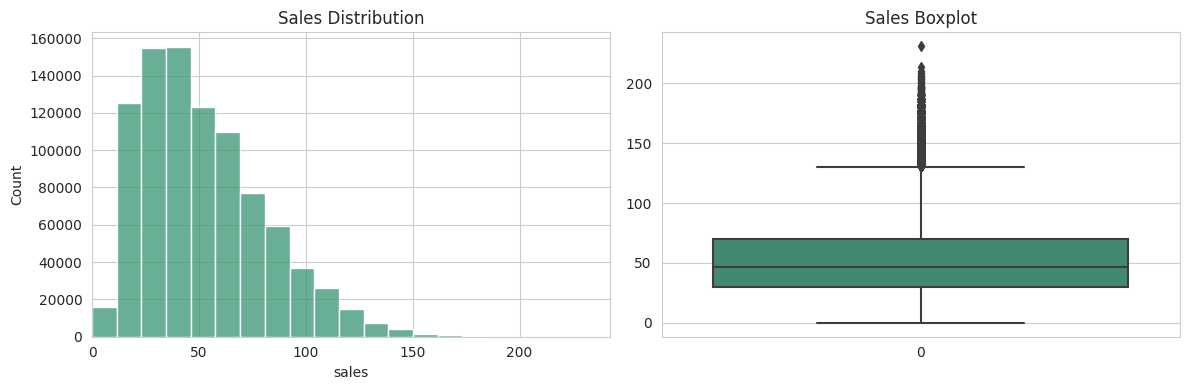

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 4))

sns.histplot(train['sales'], bins=20, ax=ax1, color='#369572')
ax1.set_title('Sales Distribution')
ax1.set_xlim(train['sales'].min())
sns.boxplot(train['sales'], ax=ax2, color='#369572')

ax2.set_title('Sales Boxplot')
# ax2.set_xlim(train['sales'].min())

plt.tight_layout()
plt.show()

In [34]:
# Remove outliers
train = train[train['sales'] < 
                    train['sales'].quantile(q = 0.98)]
train.describe()

,store,item,sales
count,"894,353.00","894,353.00","894,353.00"
mean,5.50,25.54,50.47
std,2.86,14.49,26.22
min,1.00,1.00,0.00
25%,3.00,13.00,29.00
50%,6.00,26.00,46.00
75%,8.00,38.00,68.00
max,10.00,50.00,123.00


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 894353 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   894353 non-null  int8 
 1   item    894353 non-null  int8 
 2   sales   894353 non-null  int16
dtypes: int16(1), int8(2)
memory usage: 10.2 MB


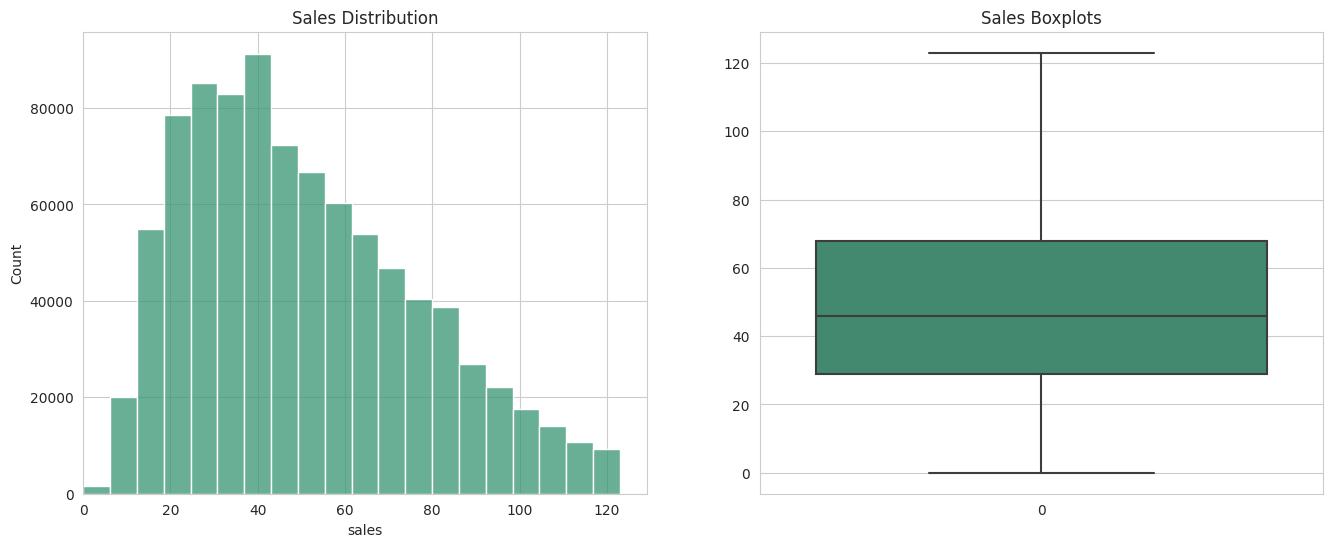

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16, 6))

sns.histplot(x=train['sales'], bins=20, ax=ax1, color='#369572')

ax1.set_title('Sales Distribution')
ax1.set_xlim(train['sales'].min())

sns.boxplot(train['sales'], ax=ax2, color='#369572')
ax2.set_title('Sales Boxplots')
# ax2.set_xlim(train['sales'].min())

plt.show()

### 2.2 Smoothening the data using Differencing and Moving Average

In [37]:
# First-order differencing
differenced_train = train['sales'].diff()

# Rolling averages
rolling_average_train = train['sales'].rolling(window=7).mean()

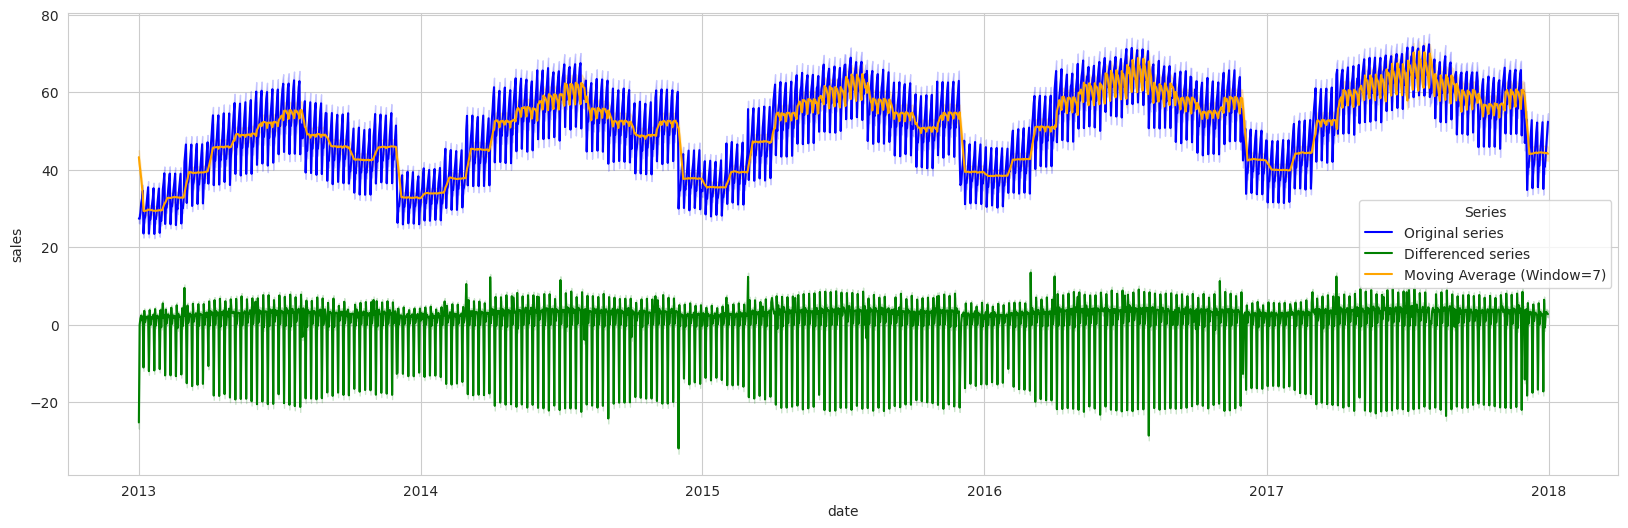

In [38]:
plt.figure(figsize=(20, 6))

# Plot the original series
sns.lineplot(data=train, x='date', y='sales', 
             color='blue', label='Original series')

# Plot the differenced series
sns.lineplot(x=differenced_train.index, y=differenced_train.values, 
             color='green', label='Differenced series')

# Plot the moving average series
sns.lineplot(x=rolling_average_train.index, y=rolling_average_train.values, 
             color='orange', label='Moving Average (Window=7)')

# Add the legend once after all the plots
plt.legend(title='Series')

plt.show()

### Observations

The first-order differencing removes the trend but not the seasonarity.

## 3. Plot the Autocorrelation

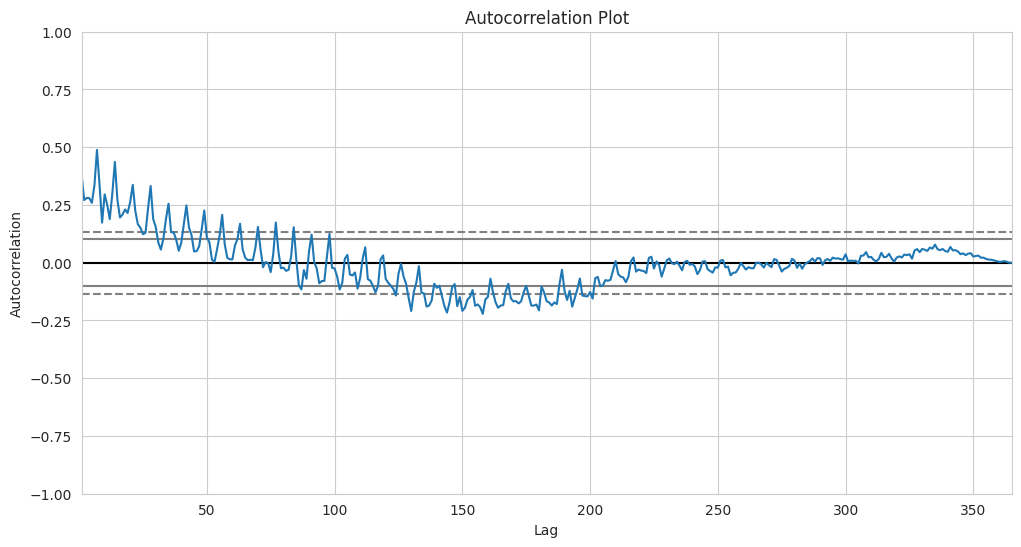

In [39]:
# Autocorrelation Plot
plt.figure(figsize=(12, 6))

autocorrelation_plot(train['sales'].values[:365])

plt.title('Autocorrelation Plot')
plt.grid()
plt.show()

The ACF plot exhibits a sinusoidal pattern.   

This is a strong indication of seasonality in our time series data.    
The repeating peaks and troughs suggest a cyclical pattern, likely related to seasonal factors.

`Key observations from the plot:`

- `Cyclic pattern:`    
    The ACF values oscillate between positive and negative, suggesting a cyclical relationship between the current value and past values.   
- `Decaying amplitude:`   
    The peaks and troughs gradually become smaller, indicating that the influence of past values on the current value decreases over time.
- `Significant lags:`    
    The ACF values are significant (outside the confidence bands) at lags that are multiples of a certain period (likely 12 months,    
    based on the context of our data). This confirms the seasonal pattern.

Based on this ACF plot, we might consider using a Seasonal ARIMA (SARIMA) model to capture both the seasonal component and    
any other trends or autoregressive/moving average components in our data.   

## 4. Stationarity Check

### 4.1 ADF test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if    
the series is stationary or not. The null and alternate hypothesis of this test are:

- Null Hypothesis: The series has a unit root.
- Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [40]:
# Set maxlag to 10 to reduce the dataset size
result = adfuller(train['sales'], maxlag=10)  

print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values: ', result[4])

ADF Statistic: -36.899
p-value: 0.000
Critical Values:  {'1%': -3.4303573118770774, '5%': -2.861543231766745, '10%': -2.566771720150838}


### Summary

p-value (0.0000) is lesser than the significance level (0.05), we reject the null hypothesis.   
The test suggests that the data is stationary.

### 4.2 KPSS test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for    
the KPSS test are opposite that of the ADF test.

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

In [41]:
# KPSS Test
result = kpss(train['sales'])

print(f'KPSS Statistic: {result[0]:.3f}')
print('p-value:', result[1])
print('Critical Values:', result[3])

KPSS Statistic: 3.633
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


### Summary

p-value (0.01) is lesser than the significance level (0.05), we reject the null hypothesis.   
The test suggests that the data is non-stationary.

Based upon the significance level of 0.05 and the p-value:

- **ADF test:** The null hypothesis is rejected. Hence, the series is stationary
- **KPSS test:** There is evidence for rejecting the null hypothesis in favour of the alternative.    
    Hence, the series is non-stationary as per the KPSS test.

The discrepancy between the ADF and KPSS test suggests that the time series might contain a deterministic trend. 

To address this, we should:

- Consider differencing the series to achieve stationarity,
- Detrend the series if a trend is visually apparent,
- Re-check stationarity after applying transformations.

## 5. Plot ACF & PACF

When analyzing a time series, we should plot ACF and PACF plots before using seasonal decomposition: 

`ACF and PACF plots`

These plots help identify the most important lags to include in a time series model, and whether there are seasonal patterns in the data.

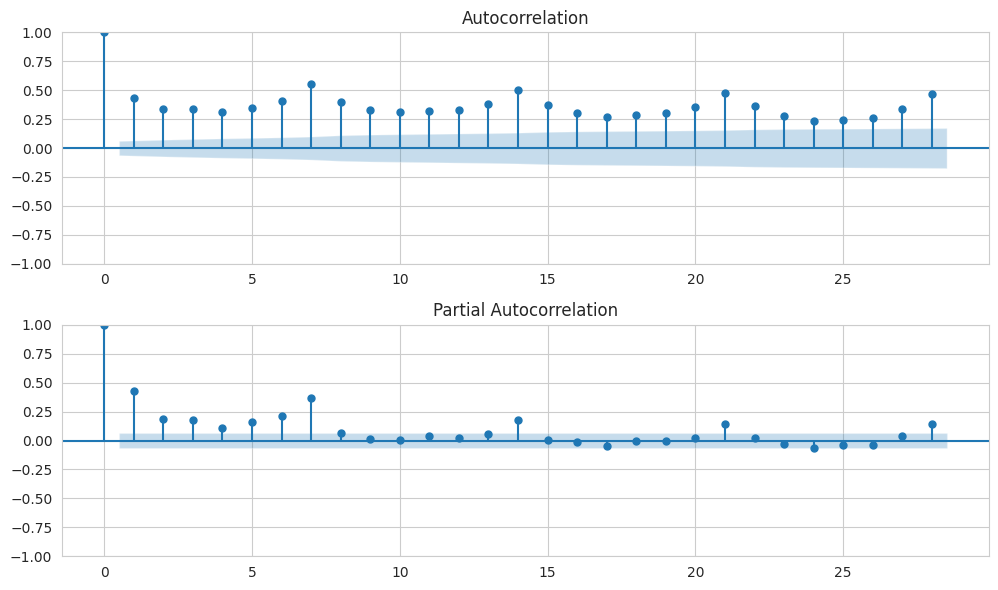

In [42]:
# Plot ACF and PACF Before Removing Seasonality:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# plt.subplot(121)
plot_acf(train.sales[:1000], lags=28, ax=axes[0])

# plt.subplot(122)
plot_pacf(train.sales[:1000], lags=28, ax=axes[1])

plt.tight_layout()
plt.show()

Both plots clearly indicate a weekly pattern in our time series data.

The significant spikes at lags 7, 14, 21, and 28 suggest a strong correlation between the current value and values from the previous week, two weeks ago, three weeks ago, and four weeks ago.

## 6. Plot the Seasonal Decomposition

This statistical technique breaks down a time series into its trend, seasonality, and residual components. The main goal of seasonal decomposition is to estimate seasonal effects so that we can create seasonally adjusted values.

- If our data is monthly, period=12 makes sense because there are 12 months in a year.
- If our data is daily, period=365 could represent annual seasonality, assuming a 365-day year.
- If our data is weekly, period=53 could represent annual seasonality, assuming a 365-day year.

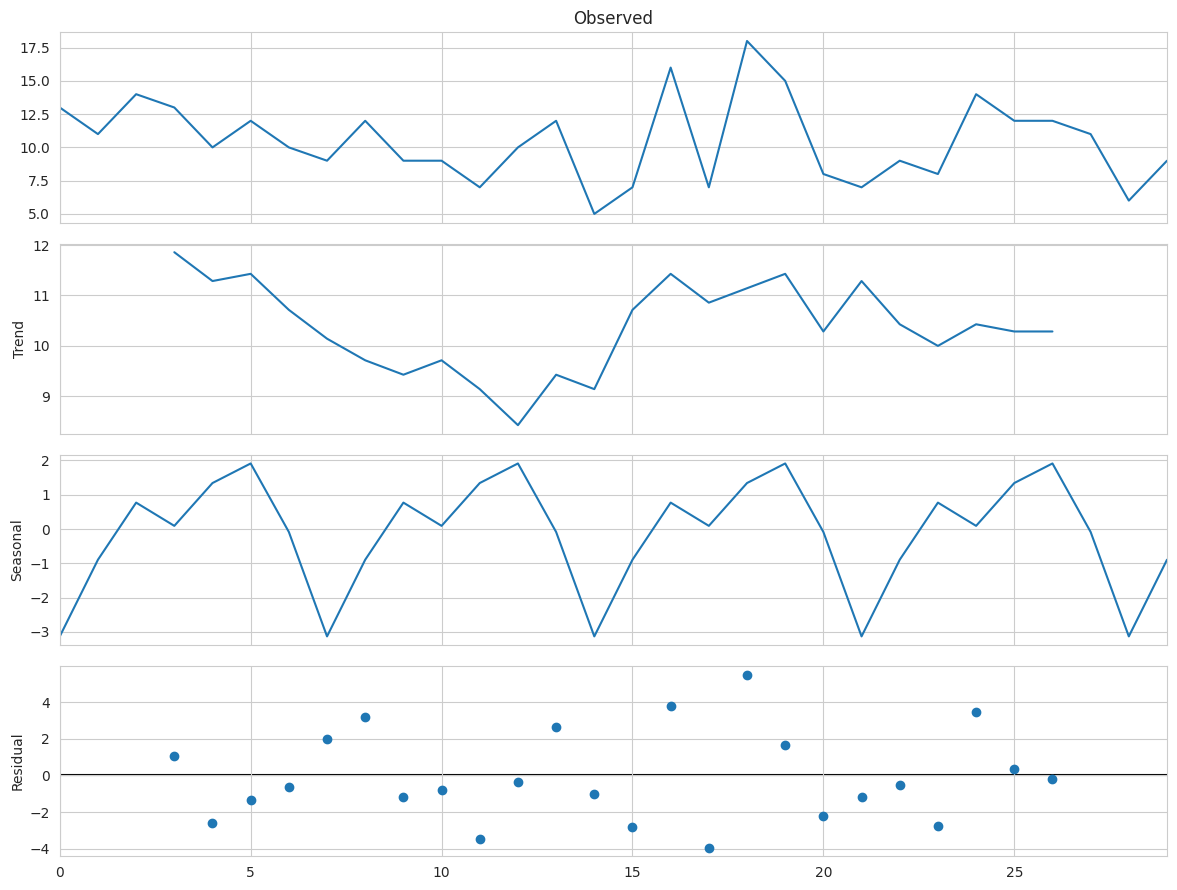

In [43]:
# Decompose the time series
plt.rcParams['figure.figsize'] = (12, 9)

result = seasonal_decompose(train['sales'].values[:30], 
                            model='additive', period=7)

# Plot the decomposition
result.plot()
plt.show()

`Weekly Seasonality:`

The fact that we see a clear weekly pattern in the ACF or PACF of the first 21 data points strongly suggests a weekly seasonality in our sales data.
The pattern (gradually grows from Monday and peaks at Saturday, then dips on Sunday) aligns with a weekly cycle.

`Data Trendy`

There is an upward trend. So the first order differencing is required to remove the trend.

## 7. Remove Trend & Seasonality

In [44]:
# Seasonal differencing - to remove trend & seasonality
differenced_seasonal = train['sales'].diff(periods=7)

# Doubt differencing - first differencing + seasonal differencing
double_differencing = train['sales'].diff().diff(periods=7)

# Deseasonalized series
result = seasonal_decompose(train['sales'], model='additive', period=7)  
seasonal = result.seasonal
deseasonalized = train['sales'] - seasonal

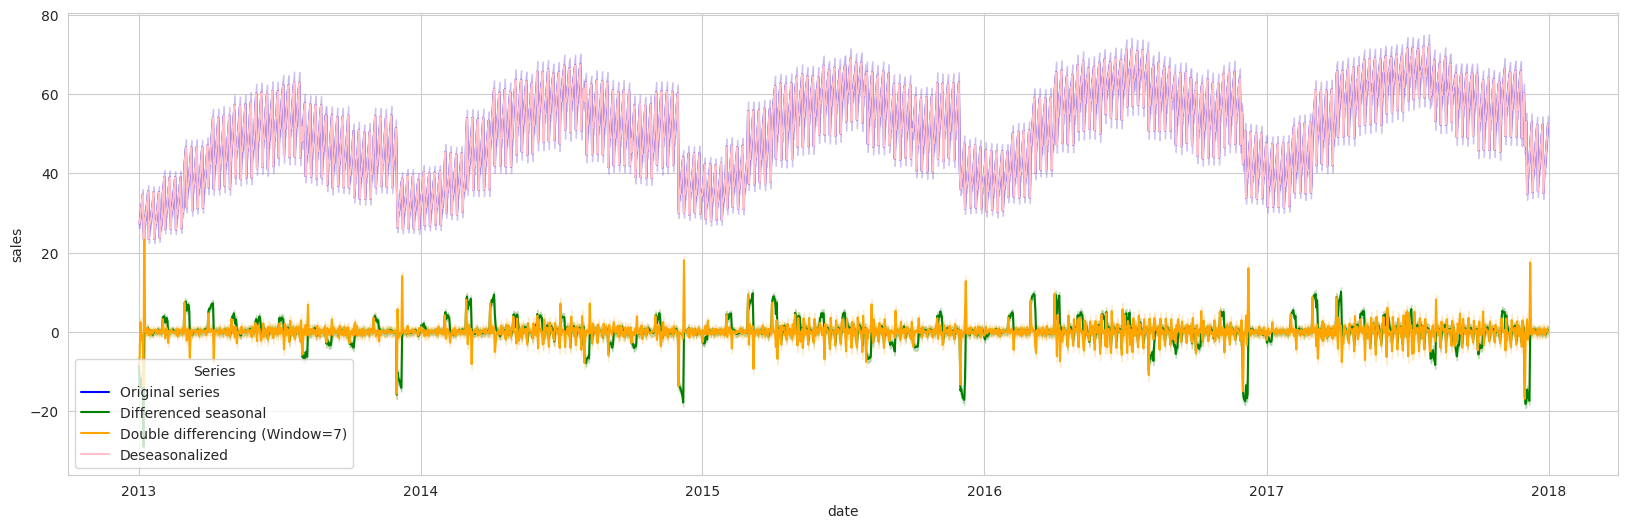

In [45]:
plt.figure(figsize=(20, 6))

# Plot the original series
sns.lineplot(data=train, x='date', y='sales', 
             color='blue', label='Original series')

# Plot the seasonal differencing
sns.lineplot(x=differenced_seasonal.index, y=differenced_seasonal.values, 
             color='green', label='Differenced seasonal')

# Plot the double differencing
sns.lineplot(x=double_differencing.index, y=double_differencing.values, 
             color='orange', label='Double differencing (Window=7)')

# Plot the deseasonalized series
sns.lineplot(x=deseasonalized.index, y=deseasonalized.values, 
             color='pink', label='Deseasonalized')

# Add the legend once after all the plots
plt.legend(title='Series')

plt.show()

### Observations

We need not only the first-order differencing but also seasonal differencing.    
Thus, SARIMA or SARIMAX would be more suitable for out data.

- Base model with order = (1, 1, 1) & seasonal order = (1, 1, 1, 7)

## 8. SARIMA Model

In [46]:
# Function to predict future sales using SARIMAX
def predict_sarimax(store, item):
    
    # Filter training data for the specific store and item
    target = train[(train['store'] == store) & (train['item'] == item)]

    # Fit SARIMAX model on training data
    model = sm.tsa.statespace.SARIMAX(target['sales'], order=(1, 1, 1), 
                                      seasonal_order=(1, 1, 1, 7)).fit(disp=False)

    # Use test data dates (first 3 months of 2018) to predict
    future_dates = test[(test['store'] == store) & (test['item'] == item)].index

    # Make predictions for future dates
    forecast = model.get_forecast(steps=len(future_dates))
    forecast_values = forecast.predicted_mean

    # Combine forecast with test data for future dates
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast_sales': forecast_values})

    return forecast_df


In [47]:
# Example: Predict for store 1, item 1
results = pd.DataFrame()

print(f'Predicting for store {1} and item {1}')
sub_results = predict_sarimax(1, 1)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 1 and item 1


,date,forecast_sales
0,2018-01-01,12.67
1,2018-01-02,15.34
2,2018-01-03,15.85
3,2018-01-04,16.78
4,2018-01-05,18.02
...,...,...
85,2018-03-27,15.33
86,2018-03-28,15.94
87,2018-03-29,16.70
88,2018-03-30,18.15


In [48]:
# Example: Predict for store 5, item 5
results = pd.DataFrame()

print(f'Predicting for store {5} and item {5}')
sub_results = predict_sarimax(5, 5)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 5 and item 5


,date,forecast_sales
0,2018-01-01,9.88
1,2018-01-02,11.51
2,2018-01-03,11.42
3,2018-01-04,12.46
4,2018-01-05,13.55
...,...,...
85,2018-03-27,11.76
86,2018-03-28,11.71
87,2018-03-29,12.65
88,2018-03-30,13.77


In [49]:
# Example: Predict for store 10, item 10
results = pd.DataFrame()

print(f'Predicting for store {10} and item {10}')
sub_results = predict_sarimax(10, 10)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 10 and item 10


,date,forecast_sales
0,2018-01-01,54.07
1,2018-01-02,58.09
2,2018-01-03,64.04
3,2018-01-04,72.96
4,2018-01-05,66.58
...,...,...
85,2018-03-27,31.84
86,2018-03-28,35.39
87,2018-03-29,44.29
88,2018-03-30,38.94


In [42]:
results = pd.DataFrame()

for i in range(1, 51):
  for j in range(1, 11):
    print(f'Predicting for store {j} and item {i}')
    sub_results = predict_sarimax(j, i)
    results = pd.concat([results, sub_results]).reset_index(drop=True)
    results['date'] = test['date']
#     print(results)
      

Predicting for store 1 and item 1
Predicting for store 2 and item 1
Predicting for store 3 and item 1
Predicting for store 4 and item 1
Predicting for store 5 and item 1
Predicting for store 6 and item 1
Predicting for store 7 and item 1
Predicting for store 8 and item 1
Predicting for store 9 and item 1
Predicting for store 10 and item 1
Predicting for store 1 and item 2
Predicting for store 2 and item 2
Predicting for store 3 and item 2
Predicting for store 4 and item 2
Predicting for store 5 and item 2
Predicting for store 6 and item 2
Predicting for store 7 and item 2
Predicting for store 8 and item 2
Predicting for store 9 and item 2
Predicting for store 10 and item 2
Predicting for store 1 and item 3
Predicting for store 2 and item 3
Predicting for store 3 and item 3
Predicting for store 4 and item 3
Predicting for store 5 and item 3
Predicting for store 6 and item 3
Predicting for store 7 and item 3
Predicting for store 8 and item 3
Predicting for store 9 and item 3
Predicting f

In [43]:
final_forecasts = pd.DataFrame(results)
final_forecasts

,date,forecast_sales
0,2018-01-01,12.67
1,2018-01-02,15.34
2,2018-01-03,15.85
3,2018-01-04,16.78
4,2018-01-05,18.02
...,...,...
44995,2018-03-27,25.03
44996,2018-03-28,29.36
44997,2018-03-29,32.32
44998,2018-03-30,37.47


In [44]:
# Save the combined DataFrame to a CSV file
final_forecasts.to_csv('store_item_forecasts.csv', index=False)

print('Predictions saved to store_item_forecasts.csv')

Predictions saved to store_item_forecasts.csv


In [45]:
submission_df = test.loc[:, ['id']]
submission_df["sales"] = final_forecasts['forecast_sales']
submission_df

,id,sales
0,0,12.67
1,1,15.34
2,2,15.85
3,3,16.78
4,4,18.02
...,...,...
44995,44995,25.03
44996,44996,29.36
44997,44997,32.32
44998,44998,37.47


In [48]:
submission_df.to_csv("submission.csv", index=False)

print('Forecasts successfully submitted.')

Forecasts successfully submitted.


## 9. SARIMAX Model

To incorporate exog (exogenous variables) properly into the SARIMAX model 

### 9.1 Data Preprocessing

In [50]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', 
                    parse_dates = ['date'])

# Reduce memory usage
# train[['store', 'item']] = train[['store', 'item']].astype('category')
# train['sales'] = pd.to_numeric(train['sales'], downcast='integer')
train['store'] =  pd.to_numeric(train['store'], downcast='integer')
train['item'] =  pd.to_numeric(train['item'], downcast='integer')
train['sales'] = pd.to_numeric(train['sales'], downcast='integer')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


In [51]:
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', 
                   parse_dates = ['date'])

# Reduce memory usage
# test['store'] = test['store'].astype('category')
# test['item'] = test['item'].astype('category')
test['store'] =  pd.to_numeric(test['store'], downcast='integer')
test['item'] =  pd.to_numeric(test['item'], downcast='integer')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int8          
 3   item    45000 non-null  int8          
dtypes: datetime64[ns](1), int64(1), int8(2)
memory usage: 791.1 KB


In [52]:
# Convert 'date' to datetime format
# train['date'] = pd.to_datetime(train['date'])
# test['date'] = pd.to_datetime(test['date'])

# train.info()

In [53]:
# Remove outliers
train = train[train['sales'] < 
                    train['sales'].quantile(q = 0.98)]
train.describe()

,date,store,item,sales
count,894353,"894,353.00","894,353.00","894,353.00"
mean,2015-06-25 05:16:47.453208832,5.50,25.54,50.47
min,2013-01-01 00:00:00,1.00,1.00,0.00
25%,2014-03-25 00:00:00,3.00,13.00,29.00
50%,2015-06-21 00:00:00,6.00,26.00,46.00
75%,2016-09-24 00:00:00,8.00,38.00,68.00
max,2017-12-31 00:00:00,10.00,50.00,123.00
std,NaN,2.86,14.49,26.22


### 9.2 Feature Engineering & Transformation

In [54]:
from datetime import date
import holidays

In [55]:
# Create a US holidays calendar
us_holidays = holidays.US()

# Check if each date is a holiday
train['IsHoliday'] = train['date'].apply(lambda x: x in us_holidays)
train['IsHoliday'] = train['IsHoliday'].astype(int)
train

,date,store,item,sales,IsHoliday
0,2013-01-01,1,1,13,1
1,2013-01-02,1,1,11,0
2,2013-01-03,1,1,14,0
3,2013-01-04,1,1,13,0
4,2013-01-05,1,1,10,0
...,...,...,...,...,...
912995,2017-12-27,10,50,63,0
912996,2017-12-28,10,50,59,0
912997,2017-12-29,10,50,74,0
912998,2017-12-30,10,50,62,0


In [56]:
# Check if a date is a weekend
def is_weekend(date):
    """
    Checks if a given date is a weekend.
    Args:
        date: A pandas Timestamp or datetime.date object.
    Returns:
        True if the date is a weekend, False otherwise.
    """

    # Weekday index starts from 0 (Monday),
    return date.weekday() >= 5  # so 5 and 6 represent Saturday and Sunday

In [57]:
# Apply the function to the 'date' column
train['is_weekend'] = train['date'].apply(is_weekend)
train['is_weekend'] = train['is_weekend'].astype(int)
train

,date,store,item,sales,IsHoliday,is_weekend
0,2013-01-01,1,1,13,1,0
1,2013-01-02,1,1,11,0,0
2,2013-01-03,1,1,14,0,0
3,2013-01-04,1,1,13,0,0
4,2013-01-05,1,1,10,0,1
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,0,0
912996,2017-12-28,10,50,59,0,0
912997,2017-12-29,10,50,74,0,0
912998,2017-12-30,10,50,62,0,1


In [58]:
# Check if each date is a holiday
test['IsHoliday'] = test['date'].apply(lambda x: x in us_holidays)
test['IsHoliday'] = test['IsHoliday'].astype(int)
test

,id,date,store,item,IsHoliday
0,0,2018-01-01,1,1,1
1,1,2018-01-02,1,1,0
2,2,2018-01-03,1,1,0
3,3,2018-01-04,1,1,0
4,4,2018-01-05,1,1,0
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,0
44996,44996,2018-03-28,10,50,0
44997,44997,2018-03-29,10,50,0
44998,44998,2018-03-30,10,50,0


In [59]:
# Apply the function to the 'date' column
test['is_weekend'] = test['date'].apply(is_weekend)
test['is_weekend'] = test['is_weekend'].astype(int)
test

,id,date,store,item,IsHoliday,is_weekend
0,0,2018-01-01,1,1,1,0
1,1,2018-01-02,1,1,0,0
2,2,2018-01-03,1,1,0,0
3,3,2018-01-04,1,1,0,0
4,4,2018-01-05,1,1,0,0
...,...,...,...,...,...,...
44995,44995,2018-03-27,10,50,0,0
44996,44996,2018-03-28,10,50,0,0
44997,44997,2018-03-29,10,50,0,0
44998,44998,2018-03-30,10,50,0,0


### 9.3 SARIMAX Model

In [60]:
# Function to predict future sales using SARIMAX
def predict_sarimax(store, item):
    
    # Filter training data for the specific store and item
    target = train[(train['store'] == store) & (train['item'] == item)]

    # Fit SARIMAX model on training data
    model = sm.tsa.statespace.SARIMAX(endog=target['sales'], 
                                    exog=target[['store', 'item', 'IsHoliday', 'is_weekend']],
                                    order=(1, 1, 1), 
                                    seasonal_order=(1, 1, 1, 7)).fit(disp=False)

    # Use test data dates to predict (assuming test contains future data for 2018)
    future_dates = test[(test['store'] == store) & (test['item'] == item)].index

    # Extract exogenous variables for future dates
    exog_future = test.loc[future_dates, ['store', 'item', 'IsHoliday', 'is_weekend']]

    # Make predictions for future dates, including exogenous variables
    forecast = model.get_forecast(steps=len(future_dates), exog=exog_future)
    forecast_values = forecast.predicted_mean

    # Optionally, get confidence intervals
    confidence_intervals = forecast.conf_int()

    # Create a DataFrame with predictions
    # forecast_df = pd.DataFrame({'date': future_dates, 'forecast_sales': forecast_values})
    forecast_df = pd.DataFrame({'date': future_dates, 
                                'store': store, 'item': item, 
                                'forecast_sales': forecast_values})
    
    forecast_df['date'] = test['date']
    forecast_df.set_index('date', inplace=True)

    return forecast_df


In [61]:
# Example: Predict for store 10, item 10
results = pd.DataFrame()

print(f'Predicting for store {10} and item {10}')
sub_results = predict_sarimax(10, 10)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 10 and item 10


,store,item,forecast_sales,date
0,10,10,55.86,2018-01-01
1,10,10,58.71,2018-01-02
2,10,10,63.03,2018-01-03
3,10,10,69.40,2018-01-04
4,10,10,66.47,2018-01-05
...,...,...,...,...
85,10,10,41.13,2018-03-27
86,10,10,43.44,2018-03-28
87,10,10,49.47,2018-03-29
88,10,10,47.76,2018-03-30


In [62]:
# results = pd.DataFrame()

# for i in range(1, 51):
#   for j in range(1, 11):
#     print(f'Predicting for store {j} and item {i}')
#     sub_results = predict_sarimax(j, i)
#     results = pd.concat([results, sub_results]).reset_index(drop=True)
#     results['date'] = test['date']
#     print(results)